In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1) Load the dataset
path = "labeled_data.csv"  # replace with your file path
df = pd.read_csv(path, encoding="utf-8", low_memory=False)
# dropping first column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
# 2) Keep only rows with exactly 3 annotators
df3 = df[df["count"] == 3].copy()

# 3) Keep rows where all three annotators agreed (one of the columns == 3)
agreement_mask = (
    (df3["hate_speech"] == 3)
    | (df3["offensive_language"] == 3)
    | (df3["neither"] == 3)
)
df_clear = df3[agreement_mask].copy()

# 4) Ensure class column is consistent or derive it from unanimous labels
def derive_class(row):
    if row["hate_speech"] == 3:
        return 0  # hate speech
    elif row["offensive_language"] == 3:
        return 1  # offensive language
    elif row["neither"] == 3:
        return 2  # neither
    return np.nan

if "class" not in df_clear.columns:
    df_clear["class"] = df_clear.apply(derive_class, axis=1)
else:
    df_clear.loc[:, "class"] = df_clear.apply(derive_class, axis=1)

# 5) Drop the count column (optional: drop the tally columns too)
df_clean = df_clear.drop(columns=["count"])

# 6) Save the cleaned dataset
df_clean.to_csv("labeled_data_clean.csv", index=False)

print("✅ Cleaned dataset saved as labeled_data_clean.csv")
print(df_clean["class"].value_counts())
print(df_clean.head())


✅ Cleaned dataset saved as labeled_data_clean.csv
class
1    13306
2     2753
0      261
Name: count, dtype: int64
   hate_speech  offensive_language  neither  class  \
0            0                   0        3      2   
1            0                   3        0      1   
2            0                   3        0      1   
6            0                   3        0      1   
7            0                   3        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
6  !!!!!!"@__BrighterDays: I can not just sit up ...  
7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...  


Data Set Establishment: Two Exploratory Plots

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Optional (wordcloud)
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except Exception:
    WORDCLOUD_AVAILABLE = False

# ---------- 0) Config ----------
RAW_PATH = "labeled_data.csv"              # path to your raw file
SAVE_CLEAN = True                          # save cleaned CSV
CLEAN_PATH = "labeled_data_clean.csv"
RANDOM_STATE = 123
sns.set(style="whitegrid", context="talk")


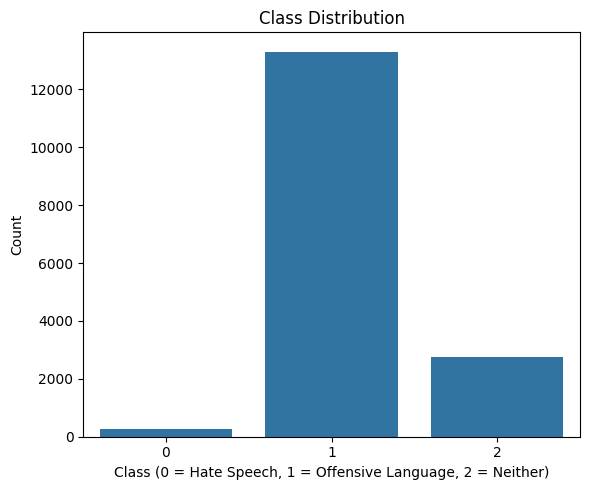

In [ ]:
# plot 1
plt.figure(figsize=(6,5))
ax = sns.countplot(x="class", data=df_clean)
ax.set_xlabel("Class (0 = Hate Speech, 1 = Offensive Language, 2 = Neither)")
ax.set_ylabel("Count")
ax.set_title("Class Distribution")
plt.tight_layout()

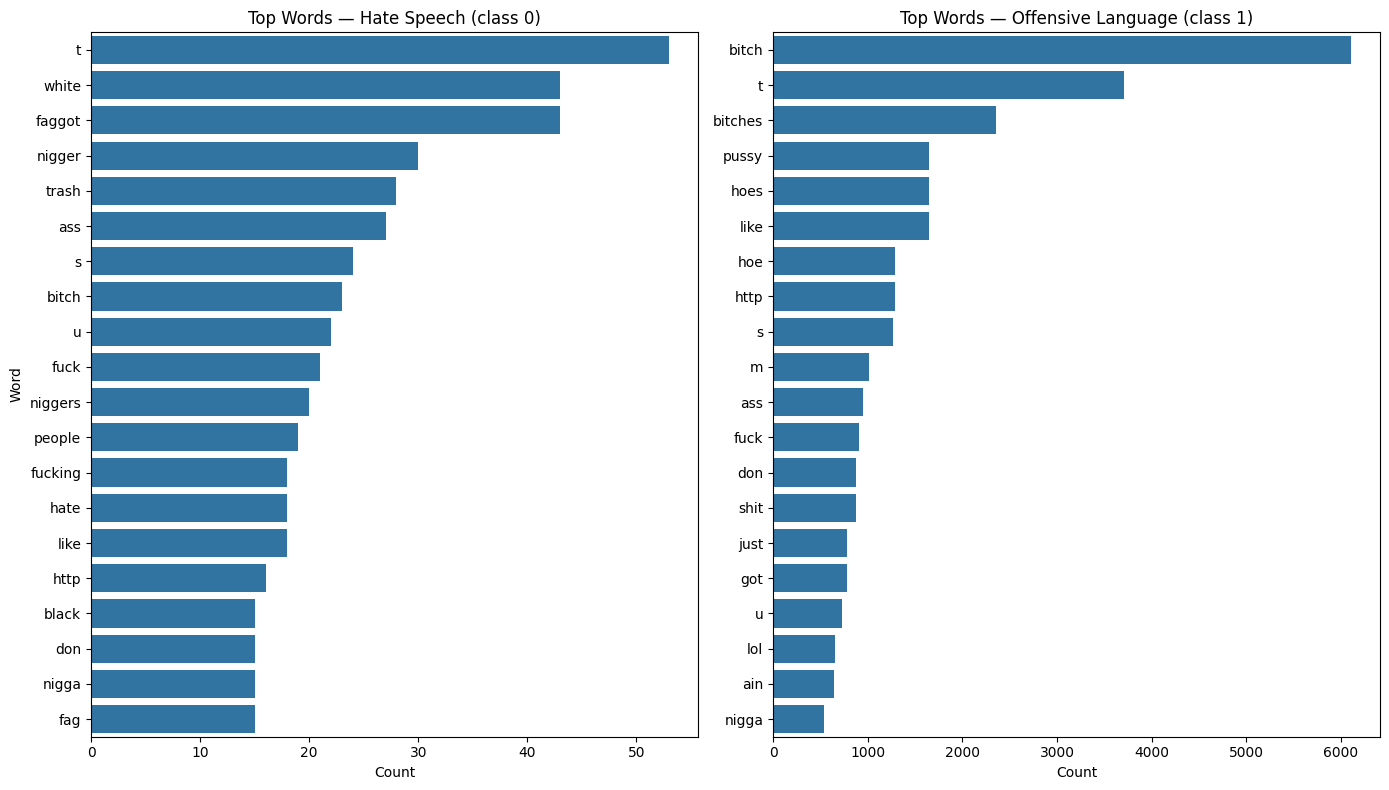

In [ ]:
# plot 2
STOPWORDS = set(ENGLISH_STOP_WORDS) | {"rt", "amp"}  # add twitter-ish tokens

def tokenize(text):
    # lowercase, keep words (alphanumeric + underscore)
    toks = re.findall(r"\b\w+\b", text.lower())
    # drop tokens that are only digits or in stopwords
    toks = [t for t in toks if not t.isdigit() and t not in STOPWORDS]
    return toks

def top_words(text_series, n=20):
    tokens = []
    for t in text_series.astype(str):
        tokens.extend(tokenize(t))
    counts = Counter(tokens)
    return pd.DataFrame(counts.most_common(n), columns=["word", "count"])

# split classes
hate_texts = df_clean[df_clean["class"] == 0]["tweet"]
off_texts  = df_clean[df_clean["class"] == 1]["tweet"]

hate_top = top_words(hate_texts, n=20)
off_top  = top_words(off_texts,  n=20)

# side-by-side barplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
sns.barplot(data=hate_top, x="count", y="word", ax=axes[0])
axes[0].set_title("Top Words — Hate Speech (class 0)")
axes[0].set_xlabel("Count"); axes[0].set_ylabel("Word")

sns.barplot(data=off_top, x="count", y="word", ax=axes[1])
axes[1].set_title("Top Words — Offensive Language (class 1)")
axes[1].set_xlabel("Count"); axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
# confusion matrix
df_bin = df_clean[df_clean["class"].isin([0, 1])].copy()
X = df_bin["tweet"].values
y = df_bin["class"].values

# TF-IDF features (unigrams + bigrams often help)
vectorizer = TfidfVectorizer(
    lowercase=True,
    tokenizer=tokenize,        # use our simple tokenizer
    ngram_range=(1,2),
    min_df=3,                  # ignore super rare terms
    max_df=0.9                 # ignore extremely common terms
)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

clf = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nBaseline Logistic Regression Accuracy (0 vs 1): {acc:.3f}")

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print("\nConfusion Matrix (rows = true, cols = pred) for classes [0, 1]:\n", cm)


Baseline Logistic Regression Accuracy (0 vs 1): 0.969

Confusion Matrix (rows = true, cols = pred) for classes [0, 1]:
 [[  34   18]
 [  67 2595]]


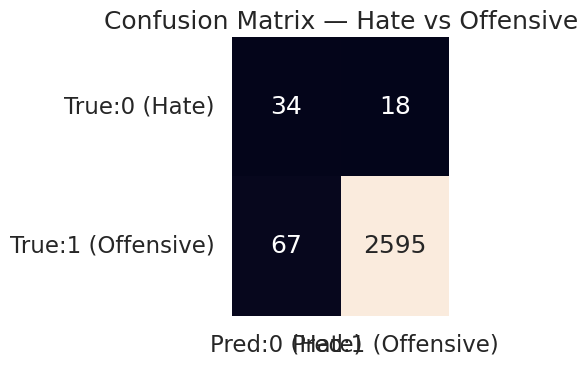


Classification Report:
                precision    recall  f1-score   support

     Hate (0)       0.34      0.65      0.44        52
Offensive (1)       0.99      0.97      0.98      2662

     accuracy                           0.97      2714
    macro avg       0.66      0.81      0.71      2714
 weighted avg       0.98      0.97      0.97      2714



In [ ]:
#heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cbar=False,
            xticklabels=["Pred:0 (Hate)", "Pred:1 (Offensive)"],
            yticklabels=["True:0 (Hate)", "True:1 (Offensive)"])
plt.title("Confusion Matrix — Hate vs Offensive")
plt.tight_layout()
plt.show()

print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=["Hate (0)", "Offensive (1)"]))

In [ ]:
def get_font_path_or_none():
    try:
        import matplotlib as mpl
        return mpl.get_data_path() + "/fonts/ttf/DejaVuSans.ttf"
    except Exception:
        return None

def make_wordcloud(text_series, title):
    if not WORDCLOUD_AVAILABLE:
        print("wordcloud not installed; skipping word clouds. Run: pip install wordcloud")
        return
    text = " ".join(map(str, text_series))
    font_path = get_font_path_or_none()
    try:
        wc = WordCloud(
            width=1200,
            height=600,
            background_color="white",
            collocations=False,
            font_path=font_path
        ).generate(text)
        plt.figure(figsize=(12,6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(title)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Word cloud failed due to font issues.")
        print("   Try passing font_path='path/to/your.ttf' below or upload a .ttf font.")
        print("   Error:", e)

make_wordcloud(hate_texts, "Word Cloud — Hate Speech (class 0)")
make_wordcloud(off_texts,  "Word Cloud — Offensive Language (class 1)")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Saved: sentiment_summary_by_class.csv
            neg                               neu                          \
           mean median       std  count      mean median       std  count   
class                                                                       
0      0.290893  0.281  0.231636    261  0.648471  0.637  0.230802    261   
1      0.266070  0.264  0.200650  13306  0.639633  0.631  0.207114  13306   
2      0.061550  0.000  0.112813   2753  0.830401  0.844  0.164431   2753   

            pos                          compound                           
           mean median       std  count      mean  median       std  count  
class                                                                       
0      0.060644    0.0  0.103726    261 -0.409708 -0.5719  0.453484    261  
1      0.094296    0.0  0.127670  13306 -0.333923 -0.5267  0.462047  13306  
2      0.108052    0.0  0.142384   2753  0.095741  0.0000  0.403498   2753  


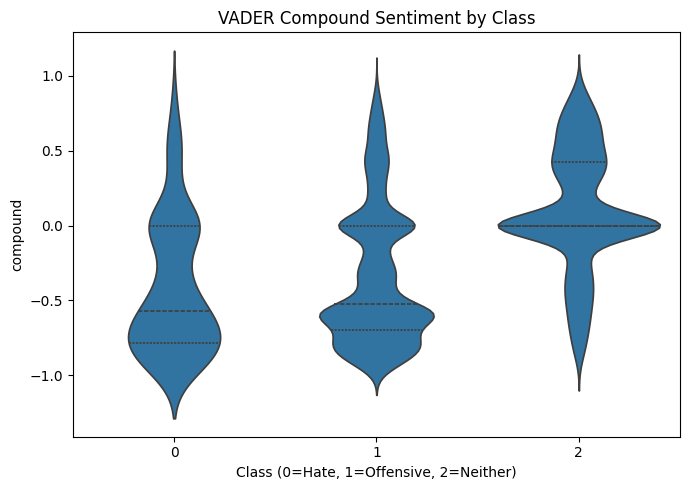

In [ ]:
# Sentiment Analysis
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
try:
    _ = nltk.data.find("sentiment/vader_lexicon.zip")
except LookupError:
    nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()

def sentiment_scores(text):
    s = sia.polarity_scores(text or "")
    return pd.Series({"neg": s["neg"], "neu": s["neu"], "pos": s["pos"], "compound": s["compound"]})

sent_df = df_clean[["tweet","class"]].copy()
sent_df = pd.concat([sent_df, sent_df["tweet"].apply(sentiment_scores)], axis=1)

# Aggregate by class
sent_summary = sent_df.groupby("class")[["neg","neu","pos","compound"]].agg(["mean","median","std","count"])
sent_summary.to_csv("sentiment_summary_by_class.csv")
print("Saved: sentiment_summary_by_class.csv")
print(sent_summary)

# Plot distributions (compound)
plt.figure(figsize=(7,5))
sns.violinplot(data=sent_df, x="class", y="compound", inner="quartile")
plt.title("VADER Compound Sentiment by Class")
plt.xlabel("Class (0=Hate, 1=Offensive, 2=Neither)")
plt.tight_layout()
plt.show()


Saved: top_words_hate_over_off.csv, top_words_off_over_hate.csv


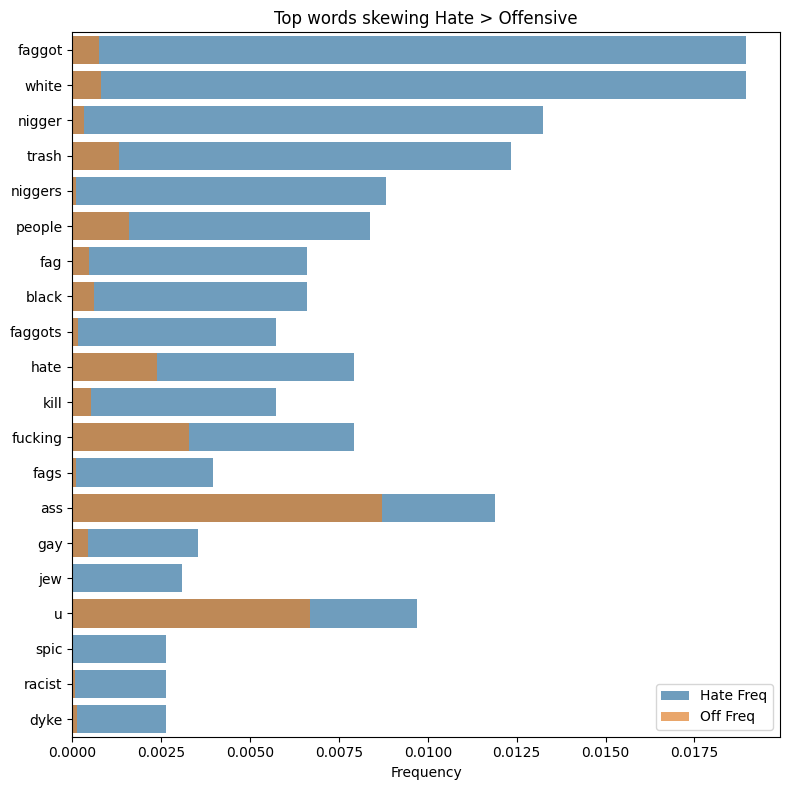

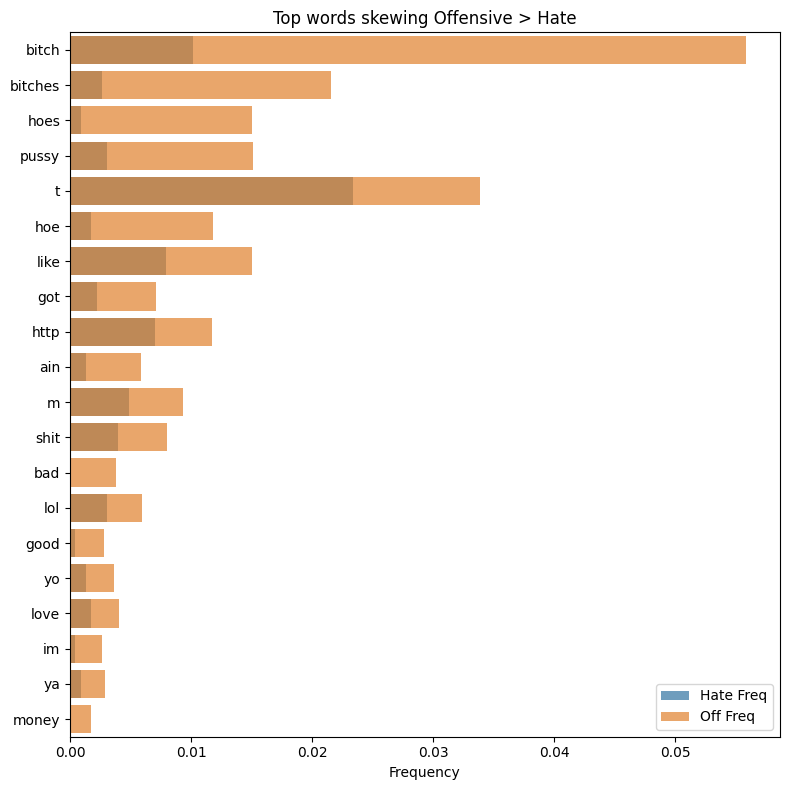

In [ ]:
# word frequency analysis
STOP = set(ENGLISH_STOP_WORDS) | {"rt", "amp"}  # add twitter-ish tokens

def tokenize(text):
    toks = re.findall(r"\b\w+\b", text.lower())
    return [t for t in toks if not t.isdigit() and t not in STOP]

def top_words(series, n=20):
    counts = Counter()
    for t in series:
        counts.update(tokenize(t))
    return pd.DataFrame(counts.most_common(n), columns=["word","count"])

hate = df_clean[df_clean["class"] == 0]["tweet"]
off  = df_clean[df_clean["class"] == 1]["tweet"]
nei  = df_clean[df_clean["class"] == 2]["tweet"]

# frequency tables
hate_counts = Counter([w for t in hate for w in tokenize(t)])
off_counts  = Counter([w for t in off  for w in tokenize(t)])

# combined frequency diff table
words = set(hate_counts) | set(off_counts)
rows = []
hate_total = sum(hate_counts.values()) or 1
off_total  = sum(off_counts.values()) or 1
for w in words:
    hc = hate_counts[w]
    oc = off_counts[w]
    hf = hc / hate_total
    of = oc / off_total
    diff = hf - of             # >0 => skews hate; <0 => skews offensive
    ratio = (hf + 1e-9) / (of + 1e-9)
    rows.append((w, hc, oc, hf, of, diff, ratio))
freq_df = pd.DataFrame(rows, columns=["word","hate_count","off_count","hate_freq","off_freq","freq_diff","freq_ratio"])
freq_df.sort_values("freq_diff", ascending=False).head(25).to_csv("top_words_hate_over_off.csv", index=False)
freq_df.sort_values("freq_diff", ascending=True).head(25).to_csv("top_words_off_over_hate.csv", index=False)
print("Saved: top_words_hate_over_off.csv, top_words_off_over_hate.csv")

# quick plots of the top 20 distinguishing words per side
def barplot_top(df_sub, title):
    plt.figure(figsize=(8,8))
    sns.barplot(data=df_sub, x="hate_freq", y="word", label="Hate Freq", alpha=0.7)
    sns.barplot(data=df_sub, x="off_freq",  y="word", label="Off Freq", alpha=0.7, color="tab:orange")
    plt.legend()
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

barplot_top(freq_df.sort_values("freq_diff", ascending=False).head(20), "Top words skewing Hate > Offensive")
barplot_top(freq_df.sort_values("freq_diff", ascending=True).head(20),  "Top words skewing Offensive > Hate")

Analysis Plan Graph